In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from math import exp, pi, sqrt
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score

import warnings
warnings.filterwarnings('ignore')

c:\Users\Daery\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
metrics = ['manhattan', 'euclidean', 'cosine']
kernels = ['uniform', 'triangular', 'epanechnikov', 'gaussian']
window_types = ['fixed', 'mutable']

In [3]:
class KNN:
    def __init__(
        self,
        window_param: int,
        window_type: str,
        kernel: str,
        metric: str,
    ):
        if window_type == 'fixed':
            self.h = window_param
        elif window_type == 'mutable':
            self.k = window_param
        else:
            raise RuntimeError("Unknown window type: ", window_type)
        self.window_type = window_type
        if kernel not in kernels:
            raise RuntimeError("Unknown kernel: ", kernel)
        self.kernel = self.__get_kernel__(kernel)
        if metric not in metrics:
            raise RuntimeError("Unknown metric: ", metric)
        self.metric = metric


    def __get_kernel__(self, kernel):
        krnls = {
            'uniform': lambda x: 0.5 if -1 < x < 1 else 0,
            'triangular': lambda x: max(0, 1 - abs(x)),
            'epanechnikov': lambda x: max(0, 0.75 * (1 - x ** 2)),
            'gaussian': lambda x: 1 / sqrt(2 * pi) * exp(- (x ** 2 / 2)),
            }
        return krnls[kernel]


    def fit(self, X, y, w):
        self.X_train, self.y_train = X, y
        self.w = w
        unique_values, _ = np.unique(self.y_train, return_counts=True)
        self.class_count = len(unique_values)
        if self.window_type == 'mutable' and self.k > len(y):
            self.k = len(y) - 1
        return self


    def predict(self, X):
        predictions = []
        all_distances, all_classes, all_weights = self.__find_neighbors__(X)
        
        for _, (distances, classes, weights) in enumerate(zip(all_distances, all_classes, all_weights)):
            scores = [0] * self.class_count
            for distance, class_label, weight in zip(distances[:-1], classes, weights[:-1]):
                div = distances[-1]
                if self.window_type == 'fixed':
                    div = self.h
                kernel_arg = distance / div
                scores[class_label] += self.kernel(kernel_arg) * weight
            predictions.append(scores.index(max(scores)))
        
        return predictions



    def __find_neighbors__(self, X):
        neighbors_count = self.__calculate_neighbors_count__()
        nn = self.__fit_nearest_neighbors__(neighbors_count)
        distances, ids = self.__find_nearest_ids__(nn, X, neighbors_count)
        classes, weights = self.__extract_classes_and_weights__(ids)
        return distances, classes, weights

    def __calculate_neighbors_count__(self):
        if self.window_type == 'mutable':
            return self.k + 1
        else:
            return min(int(sqrt(len(self.X_train))), len(self.X_train) - 1)

    def __fit_nearest_neighbors__(self, neighbors_count):
        nn = NearestNeighbors(n_neighbors=neighbors_count, metric=self.metric)
        nn.fit(self.X_train)
        return nn

    def __find_nearest_ids__(self, nn, X, neighbors_count):
        distances, ids = nn.kneighbors(X, n_neighbors=neighbors_count)
        return distances, ids

    def __extract_classes_and_weights__(self, ids):
        classes, weights = [], []
        for i in ids:
            classes.append(self.y_train[i].tolist())
            weights.append([self.w[j] for j in i])
        return classes, weights


In [4]:
DATASET_PATH = "Raisin_Dataset.csv"
df = pd.read_csv(DATASET_PATH)
df

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
0,87524,442.246011,253.291155,0.819738,90546,0.758651,1184.040,Kecimen
1,75166,406.690687,243.032436,0.801805,78789,0.684130,1121.786,Kecimen
2,90856,442.267048,266.328318,0.798354,93717,0.637613,1208.575,Kecimen
3,45928,286.540559,208.760042,0.684989,47336,0.699599,844.162,Kecimen
4,79408,352.190770,290.827533,0.564011,81463,0.792772,1073.251,Kecimen
...,...,...,...,...,...,...,...,...
895,83248,430.077308,247.838695,0.817263,85839,0.668793,1129.072,Besni
896,87350,440.735698,259.293149,0.808629,90899,0.636476,1214.252,Besni
897,99657,431.706981,298.837323,0.721684,106264,0.741099,1292.828,Besni
898,93523,476.344094,254.176054,0.845739,97653,0.658798,1258.548,Besni


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             900 non-null    int64  
 1   MajorAxisLength  900 non-null    float64
 2   MinorAxisLength  900 non-null    float64
 3   Eccentricity     900 non-null    float64
 4   ConvexArea       900 non-null    int64  
 5   Extent           900 non-null    float64
 6   Perimeter        900 non-null    float64
 7   Class            900 non-null    object 
dtypes: float64(5), int64(2), object(1)
memory usage: 56.4+ KB


In [6]:
df['Class'] = df['Class'].apply(lambda x : 1 if x == 'Kecimen' else 0)
y = df['Class']
X = df.drop(['Class'], axis=1)

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y.to_numpy(), test_size=0.25, random_state=42)

In [8]:
def to_study(trial):
    window_type = trial.suggest_categorical("Window", window_types)
    window_param = trial.suggest_float("h", 0.01, 1) if window_type == 'fixed' else trial.suggest_int("k", 1, 1000)
    kernel = trial.suggest_categorical("Kernel", kernels)
    metric = trial.suggest_categorical("Metric", metrics)
    predictions = KNN(window_param, window_type, kernel, metric).fit(X_train, y_train, np.ones(len(y_train))).predict(X)
    return balanced_accuracy_score(y.to_list(), predictions)

study = optuna.create_study(direction="maximize")
study.optimize(to_study, n_trials=100)
best_fixed = study.best_trial
print("Best value:", study.best_value)
print("Best hyperparameters:", study.best_params)


[I 2024-04-17 13:02:21,788] A new study created in memory with name: no-name-748c2922-1b51-43ab-9fe2-aeaaf596c24a
[I 2024-04-17 13:02:22,585] Trial 0 finished with value: 0.8566666666666667 and parameters: {'Window': 'mutable', 'k': 738, 'Kernel': 'triangular', 'Metric': 'cosine'}. Best is trial 0 with value: 0.8566666666666667.
[I 2024-04-17 13:02:23,408] Trial 1 finished with value: 0.8555555555555556 and parameters: {'Window': 'mutable', 'k': 978, 'Kernel': 'epanechnikov', 'Metric': 'cosine'}. Best is trial 0 with value: 0.8566666666666667.
  File "c:\Users\Daery\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Daery\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Daery\AppData\Local\Progra

Best value: 0.9577777777777778
Best hyperparameters: {'Window': 'fixed', 'h': 0.06975486916473478, 'Kernel': 'gaussian', 'Metric': 'euclidean'}


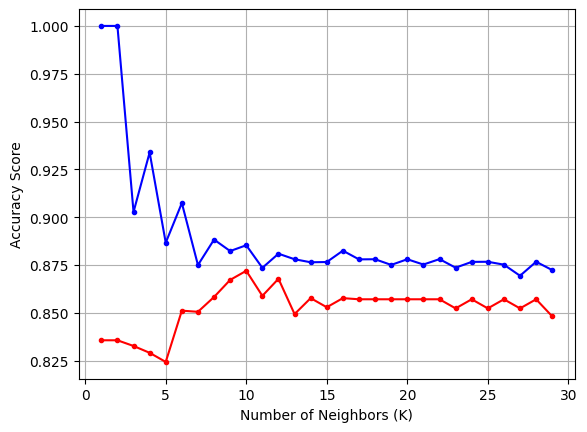

In [9]:
score_train = []
score_test = []
for i in range(1, 30):
    knn = KNN(i, 'mutable', 'gaussian', 'euclidean').fit(X_train, y_train, np.ones(len(y_train)))
    res = knn.predict(X_test)
    score_test.append(balanced_accuracy_score(y_test, res))
    res = knn.predict(X_train)
    score_train.append(balanced_accuracy_score(y_train, res))
    
plt.plot(range(1, 30), score_train, marker='.', linestyle='-', color='b', label='Train')
plt.plot(range(1, 30), score_test, marker='.', linestyle='-', color='r', label='Test')

plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Accuracy Score')
plt.grid(True)

### LOWESS

In [10]:
def lowess(knn, alpha):
    w = []
    anomalies = []
    for i in range(len(X_train)):
        n_X = np.delete(X_train, i, axis=0)
        n_y = np.delete(y_train, i, axis=0)
        preds = knn.fit(n_X, n_y, np.ones(len(n_y))).predict([X_train[i]])[0]
        if preds == y_train[i]:
            w.append(1)
        else:
            anomalies.append(i)
            w.append(alpha)
    return w, anomalies


In [11]:
def get_accuracy(model, w, X, y):
    predictions = model.fit(X_train, y_train, w).predict(X)
    return balanced_accuracy_score(y, predictions)

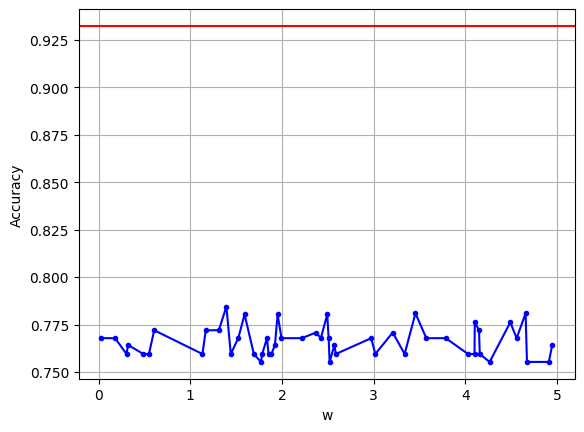

In [12]:
import random
knn_model_my = KNN(
        window_param=0.7677965913777296,
        window_type='fixed',
        kernel='triangular',
        metric='manhattan',)
base = balanced_accuracy_score(y, knn_model_my.fit(X_train, y_train, np.ones(len(y_train))).predict(X))

x = []
y = []
for i in range(50):
    w = random.random() * 5
    x.append(w)
    prior_weights, _ = lowess(knn_model_my, w)
    lowess_preds = get_accuracy(knn_model_my, prior_weights, X_test, y_test)
    y.append(lowess_preds)


x.sort()
plt.plot(x, y, marker='.', linestyle='-', color='b', label='LOWESS Accuracy')
plt.xlabel('w')
plt.ylabel('Accuracy')
plt.grid(True)
plt.axhline(y=base, color='red', linestyle='-', label='Base Accuracy')

In [13]:
_, anomalies = lowess(knn_model_my, 0)

In [14]:
def get_accuracy_lib(model, X_t, y_t, X):
    predictions = model.fit(X_t, y_t).predict(X)
    return balanced_accuracy_score(y_test, predictions)

X_sampled, y_sampled = np.delete(X_train, anomalies, axis=0), np.delete(y_train, anomalies, axis=0)

lib_knn = KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, n_neighbors=50, metric='euclidean')
print("Old: ", get_accuracy_lib(lib_knn, X_train, y_train, X_test))
print("New: ", get_accuracy_lib(lib_knn, X_sampled, y_sampled, X_test))


Old:  0.8565476190476191
New:  0.8523809523809525
